In [27]:
# !wget https://www.dropbox.com/sh/q4dehgdtbo0b6vt/AABFoMwAxqEQWQnl_xQYY2fsa?dl=1 -O dataset.zip

In [28]:
# !unzip dataset.zip

**First, we'll load all the captions, then pair the training and validation photo names with their respective captions.**

In [29]:
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

In [30]:
# Loading all the descriptions (captions)

file_path = '/content/Flickr8k_text/Flickr8k.token.txt'
file = open(file_path, 'r')
doc = file.read()
file.close()

descriptions = load_descriptions(doc)
print(f"Loaded {len(descriptions)} descriptions.")


Loaded 8092 descriptions.


In [31]:
# Loading the train and validation dataset (image names)

def load_set(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    images = text.split('\n')
    images = [img for img in images if img != '']
    return set(images)

# Load datasets
train_images = load_set('/content/Flickr8k_text/Flickr_8k.trainImages.txt')
dev_images = load_set('/content/Flickr8k_text/Flickr_8k.devImages.txt')

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(dev_images)}")


Training images: 6000
Validation images: 1000


In [32]:
# Filtering the train and validation captions from whole descriptions

def filtered(descriptions, dataset):
    filtered_descriptions = dict()
    for key, desc_list in descriptions.items():
        if key+'.jpg' in dataset:
            filtered_descriptions[key] = desc_list
    return filtered_descriptions

train_descriptions = filtered(descriptions, train_images)
dev_descriptions = filtered(descriptions, dev_images)

print(f"train_descriptions: {len(train_descriptions)}")
print(f"dev_descriptions: {len(dev_descriptions)}")


train_descriptions: 6000
dev_descriptions: 1000


In [33]:
import string

# Preprocesses descriptions by converting to lowercase, removing punctuation, and adding start and end tokens

def preprocess_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word) > 1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] = '<cap_start> ' + ' '.join(desc) + ' <cap_end>'
    return descriptions


train_descriptions = preprocess_descriptions(train_descriptions)
dev_descriptions = preprocess_descriptions(dev_descriptions)


In [66]:
print(list(train_descriptions.items())[0])

('1000268201_693b08cb0e.jpg', ['<cap_start> child in pink dress is climbing up set of stairs in an entry way <cap_end>', '<cap_start> girl going into wooden building <cap_end>', '<cap_start> little girl climbing into wooden playhouse <cap_end>', '<cap_start> little girl climbing the stairs to her playhouse <cap_end>', '<cap_start> little girl in pink dress going into wooden cabin <cap_end>'])


In [35]:
# Function to encode images using InceptionV3 model and save the encodings as pickle files

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tqdm import tqdm
import pickle
import os

inception = InceptionV3(weights='imagenet')
model_inception = Model(inputs=inception.input, outputs=inception.layers[-2].output)

def encode_images(model, images, image_folder, output_path):
    encoded_images = {}
    for img_id in tqdm(images, desc="Encoding images"):
        image_path = os.path.join(image_folder, img_id)
        img = load_img(image_path, target_size=(299, 299))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feature = model.predict(img)
        feature = np.squeeze(feature)

        encoded_images[img_id] = feature
    with open(output_path, 'wb') as f:
        pickle.dump(encoded_images, f)
    print("All images encoded and saved successfully.")

image_folder = '/content/Flicker8k_Dataset'
train_output_path = 'encoded_train_images.pkl'
val_output_path = 'encoded_dev_images.pkl'

# encode_images(model_inception, train_images, image_folder, train_output_path)
# encode_images(model_inception, dev_images, image_folder, val_output_path)


In [36]:
# loading the upper encoded files

import pickle

def load_encoded_images(file_path):
    with open(file_path, 'rb') as file:
        encoded_images = pickle.load(file)
    return encoded_images

dev_photos = load_encoded_images('/content/encoded_dev_images.pkl')
photos = load_encoded_images('/content/encoded_train_images.pkl')


In [ ]:
# Append '.jpg' extension to image keys in train_descriptions and dev_descriptions to match image filenames

train_descriptions = {key + '.jpg': desc for key, desc in train_descriptions.items() if key + '.jpg' in photos}

dev_descriptions = {key + '.jpg': desc for key, desc in dev_descriptions.items() if key + '.jpg' in dev_photos}


**Now with train_descriptions and dev_descriptions, we're ready for future data generator usage in training and validation**

In [38]:
# Create tokenizer for training descriptions and calculate vocabulary size and maximum length of descriptions

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def create_tokenizer(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_desc)
    return tokenizer

def max_length(descriptions):
    all_desc = [desc for key in descriptions.keys() for desc in descriptions[key]]
    return max(len(d.split()) for d in all_desc)

tokenizer = create_tokenizer(train_descriptions)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
max_len = max_length(train_descriptions)

print(f'Vocabulary Size: {vocab_size}')
print(f'Maximum Length: {max_len}')


Vocabulary Size: 7577
Maximum Length: 34


In [54]:
# Now , make a model architecture using a combination of a feature extractor, sequence model, and decoder model

from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


def define_model(vocab_size, max_length):
    # Feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)

    # Sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(128)(se2)

    # Decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(512, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

    model.summary()

    return model


In [55]:
# defining model

model_caption = define_model(vocab_size, max_len)
model_caption

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 34)]                 0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 2048)]               0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 34, 256)              1939712   ['input_11[0][0]']            
                                                                                                  
 dropout_6 (Dropout)         (None, 2048)                 0         ['input_10[0][0]']            
                                                                                            

**Now we will define a function to create sequences and batches for training**

In [52]:

def create_sequences_batches(tokenizer, max_length, descriptions, photos, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key, desc_list in descriptions.items():
            if key in photos:
                photo = photos[key]
                for desc in desc_list:
                    seq = tokenizer.texts_to_sequences([desc])[0]
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        X1.append(photo)
                        X2.append(in_seq)
                        y.append(out_seq)
                        n += 1
                        if n == batch_size:
                            yield [[np.array(X1), np.array(X2)], np.array(y)]
                            X1, X2, y = [], [], []
                            n = 0
        if n > 0:
            yield [[np.array(X1), np.array(X2)], np.array(y)]
            X1, X2, y = [], [], []


**lets train the model , first we create training and validation data batches**

In [56]:
batch_size = 16
steps_per_epoch = len(train_descriptions) // batch_size
devidation_steps = len(dev_descriptions) // batch_size

# Creating generators for training and validation data
train_generator = create_sequences_batches(tokenizer, max_len, train_descriptions, photos, vocab_size, batch_size)
dev_generator = create_sequences_batches(tokenizer, max_len, dev_descriptions, dev_photos, vocab_size, batch_size)

# Fit the model without EarlyStopping
model_caption.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_data=dev_generator,
    validation_steps=devidation_steps,
    verbose=1
)

Epoch 1/20
375/375 [==============================] - 88s 215ms/step - loss: 5.2356 - accuracy: 0.2283 - val_loss: 4.8325 - val_accuracy: 0.2460
Epoch 2/20
375/375 [==============================] - 87s 233ms/step - loss: 4.6269 - accuracy: 0.2742 - val_loss: 4.4756 - val_accuracy: 0.3125
Epoch 3/20
375/375 [==============================] - 78s 209ms/step - loss: 4.5193 - accuracy: 0.2977 - val_loss: 4.3728 - val_accuracy: 0.3065
Epoch 4/20
375/375 [==============================] - 79s 210ms/step - loss: 4.3985 - accuracy: 0.3038 - val_loss: 4.2561 - val_accuracy: 0.3065
Epoch 5/20
375/375 [==============================] - 90s 239ms/step - loss: 4.2777 - accuracy: 0.3220 - val_loss: 4.1314 - val_accuracy: 0.3377
Epoch 6/20
375/375 [==============================] - 78s 207ms/step - loss: 4.1709 - accuracy: 0.3167 - val_loss: 4.3810 - val_accuracy: 0.2984
Epoch 7/20
375/375 [==============================] - 78s 208ms/step - loss: 4.2160 - accuracy: 0.3235 - val_loss: 3.9049 - val_ac

In [42]:
model_caption.save('trained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
import matplotlib.pyplot as plt

def generate_image_caption(image_path, model_inception, model_caption, tokenizer, max_len):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    # Predict the features with InceptionV3 model which we defined before
    feature = model_inception.predict(img).squeeze()

    # Generate caption
    in_text = '<cap_start>'
    for _ in range(max_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model_caption.predict([feature.reshape((1, -1)), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = next((word for word, index in tokenizer.word_index.items() if index == yhat), None)
        if word is None or word == 'cap':
            break
        in_text += ' ' + word

    caption = in_text.split(' ', 1)[1] if ' ' in in_text else in_text

    plt.imshow(load_img(image_path))
    plt.axis('off')
    plt.show()

    print("Caption:", caption)

1/1 [==============================] - 1s 511ms/step


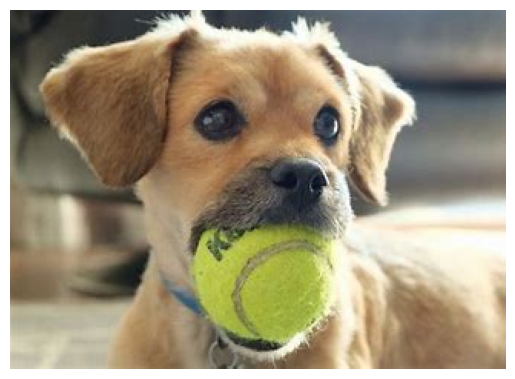

Caption: two dogs are running through the grass


In [58]:
new_image_path = '/content/OIP (1).jpg'

caption = generate_image_caption(new_image_path, model_inception, model_caption, tokenizer, max_len)
